### Outdoor Temperature Preprocessing

The file `LLEC_B665_WS_23_24.xlsx`, published on Zenodo ([DOI: 10.5281/zenodo.14810476](https://doi.org/10.5281/zenodo.14810476)), contains high-resolution measurement data from experimental buildings at the Living Lab Energy Campus (LLEC) during winter 2023–2024. 

For use in our reinforcement learning (RL) framework, we extract the column `temp_amb [°C]`, representing the ambient (outdoor) temperature. The original data is recorded at a 1-minute resolution. To reduce computational complexity and align with the simulation step size, the time series is resampled to 5-minute intervals by computing the mean value for each interval. The resulting smoothed outdoor temperature profile is used as an external input signal in the building control environment.


In [1]:
import os
import pandas as pd # For loading and processing CSV files
import numpy as np   # Optional: for numerical operations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

folder = "../data"
file = "LLEC_B665_WS_23_24.xlsx"
file_path = os.path.join(folder, file)

# Load Excel file with datetime parsing and index assignment
df = pd.read_excel(file_path, index_col=0, parse_dates=True)

In [2]:
# Optional: rename the index to 'Time' for clarity
df.index.name = 'Time'

# Extract ambient (outdoor) temperature
outdoor_temp = df['temp_amb [°C]']

# Resample to 5-minute intervals using mean aggregation
outdoor_temp_5min = outdoor_temp.resample('5min').mean()
outdoor_temp_5min = outdoor_temp_5min.round(2)

# Display the first entries
print(outdoor_temp_5min.head())

# Save to CSV file
outdoor_temp_5min.to_csv("../data/LLEC_outdoor_temperature_data.csv", index_label="Time")

missing_count = outdoor_temp_5min.isna().sum()
print(f"Number of missing values in resampled data: {missing_count}")

Time
2023-12-13 00:00:00    9.70
2023-12-13 00:05:00    9.68
2023-12-13 00:10:00    9.60
2023-12-13 00:15:00    9.60
2023-12-13 00:20:00    9.60
Freq: 5min, Name: temp_amb [°C], dtype: float64
Number of missing values in resampled data: 6052


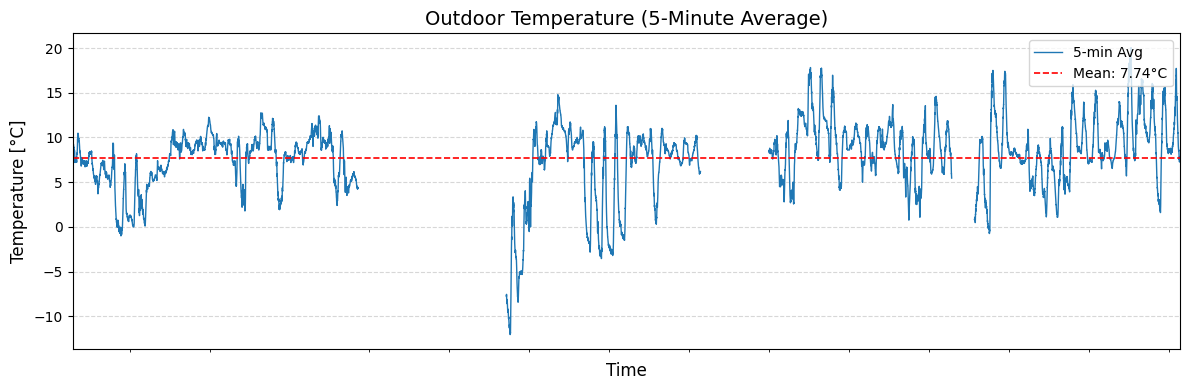

In [3]:
# Compute the average temperature
mean_temp = outdoor_temp_5min.mean()

# Set a larger plot size
plt.figure(figsize=(12, 4))

# Plot the resampled outdoor temperature
outdoor_temp_5min.plot(color='tab:blue', linewidth=1, label='5-min Avg')

# Plot the mean temperature as a horizontal dashed line
plt.axhline(y=mean_temp, color='red', linestyle='--', linewidth=1.2, label=f'Mean: {mean_temp:.2f}°C')

# Title and axis labels
plt.title("Outdoor Temperature (5-Minute Average)", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Temperature [°C]", fontsize=12)

# Format x-axis with monthly ticks
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Show legend
plt.legend(loc='upper right')

# Optional: tighter layout and grid
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Show plot
plt.show()

In [4]:
# Drop all NaN values
outdoor_temp_5min_cleaned = outdoor_temp_5min.dropna()

# Reset index to make 'Time' a regular column instead of datetime index
outdoor_temp_5min_cleaned = outdoor_temp_5min_cleaned.reset_index()

# Rename columns for clarity (optional but clean)
outdoor_temp_5min_cleaned.columns = ['Time', 'OutdoorTemperature [°C]']

# Save to CSV without using index
outdoor_temp_5min_cleaned.to_csv("../data/LLEC_outdoor_temperature_data.csv", index=False)
folder = "data"
clean_file = "LLEC_outdoor_temperature_data.csv"
clean_file_path = os.path.join(folder, file)

In [5]:
if clean_file_path.endswith('.csv'):
    df = pd.read_csv(clean_file_path)
elif clean_file_path.endswith('.xlsx'):
    df = pd.read_excel(clean_file_path, engine='openpyxl')
else:
    raise ValueError("Unsupported file format. Please use .csv or .xlsx")
# Display the first few rows of the cleaned DataFrame
print(clean_file_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data/LLEC_B665_WS_23_24.xlsx'

In [ ]:
# If ‘Time’ is not yet datetime:
df['Time'] = pd.to_datetime(df['Time'])

# Plot
plt.figure(figsize=(12, 4))
plt.plot(df["temp_amb [°C]"], color='tab:blue', linewidth=1)

# Title and axis labels
plt.title("Outdoor Temperature Time Series", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Temperature [°C]", fontsize=12)

# Optional: grid and layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()

df[["temp_amb [°C]"]].to_csv("../data/LLEC_outdoor_temperature_5min_data.csv", index=False)

# Read the CSV file
df = pd.read_csv("../data/LLEC_outdoor_temperature_5min_data.csv")

# Remove NaN entries from the temperature column
df_clean = df.dropna(subset=["temp_amb [°C]"])

# Reset the index
df_clean.reset_index(drop=True, inplace=True)

# Save the cleaned CSV
df_clean.to_csv("../data/LLEC_outdoor_temperature_5min_data.csv", index=False)

print(f"Cleaned and saved: {df_clean.shape[0]} rows")

# Read the cleaned CSV file
df = pd.read_csv("../data/LLEC_outdoor_temperature_5min_data.csv")

# Plot the temperature time series
plt.figure(figsize=(12, 4))
plt.plot(df["temp_amb [°C]"], label="Outdoor Temperature", linewidth=1)

# Plot styling
plt.title("Outdoor Temperature Over Time")
plt.xlabel("Time Step (5-minute intervals)")
plt.ylabel("Temperature [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

df = pd.read_csv("../data/LLEC_outdoor_temperature_5min_data.csv")
print(df.columns)     # displays all column names
print(df.head())      # first lines to recognize the timestamp

In [ ]:
# Define paths to synthetic and measured data
results_dir_synthetic = "results/temperature"                   # synthetic data (e.g., simulated)
results_dir_measured = "results/temperature/outdoor_data"       # measured real-world outdoor temperature data

# Valid result file suffixes
valid_suffixes = ("_best.csv", "PID_Control.csv", "PI_Control.csv", "Fuzzy_Control.csv")

# Load results from one directory
def load_results_from_directory(directory):
    results_local = {}
    avg_rewards_local = {}

    if os.path.isdir(directory):
        for filename in sorted(os.listdir(directory)):
            if filename.endswith(valid_suffixes) or ("MPC_Control" in filename and filename.endswith(".csv")):
                file_path = os.path.join(directory, filename)
                model_name = filename.replace("eval_", "").replace(".csv", "").replace("_", " ").strip()
                try:
                    df = pd.read_csv(file_path, engine="python", on_bad_lines="error")
                    df.columns = df.columns.str.strip()
                    avg_reward = df.groupby("episode")["reward"].sum().mean()
                    results_local[model_name] = df
                    avg_rewards_local[model_name] = avg_reward
                except Exception as e:
                    print(f"Error loading '{filename}' from '{directory}': {e}")
    else:
        print(f"Directory '{directory}' does not exist.")
    
    return results_local, avg_rewards_local

# Load synthetic and measured results
results_synthetic, avg_rewards_synthetic = load_results_from_directory(results_dir_synthetic)
results_measured, avg_rewards_measured = load_results_from_directory(results_dir_measured)

In [ ]:
# Select first model (for debugging/inspection)
first_model_synthetic = next(iter(results_synthetic))
first_model_measured = next(iter(results_measured))
print("First model in synthetic results:", first_model_synthetic)
print("First model in measured results:", first_model_measured)

# Group temperature data for baseline plotting
grouped_synthetic = results_synthetic[first_model_synthetic].groupby('time_step')
grouped_measured = results_measured[first_model_measured].groupby('time_step')

# Extract synthetic reference temperature profile
target_temperature_schedule = grouped_synthetic['T_set'].mean().values
t_out_origin_schedule_synthetic = grouped_synthetic['T_out'].mean()
t_out_origin_schedule_measured = grouped_measured['T_out'].mean()
target_temperature = target_temperature_schedule.mean()

# Normalize model labels
def rename_models(results_dict):
    renamed = {}
    for key, df in results_dict.items():
        if 'algorithm' in df.columns and 'seed' in df.columns:
            model_label = f"{df['algorithm'].iloc[0].upper()}_seed{df['seed'].iloc[0]}"
        else:
            model_label = key
        renamed[model_label] = df
    return renamed

# Rename model keys
results_renamed_synthetic = rename_models(results_synthetic)
results_renamed_measured = rename_models(results_measured)

# Select desired model
desired_model = "PPO_seed58"
results_renamed_synthetic = {k: v for k, v in results_renamed_synthetic.items() if k == desired_model}
results_renamed_measured = {k: v for k, v in results_renamed_measured.items() if k == desired_model}

# Generate consistent color mapping per episode
selected_df = results_renamed_synthetic[desired_model]
unique_episodes = sorted(selected_df['episode'].unique())
episode_colors = sns.color_palette("Blues", n_colors=len(unique_episodes))
episode_color_map = {ep: episode_colors[i] for i, ep in enumerate(unique_episodes)}

# Axis range collector
def collect_axis_range(results_dict):
    all_time_steps = []
    all_T_out_values = []
    for df in results_dict.values():
        for episode in df['episode'].unique():
            df_ep = df[df['episode'] == episode].groupby('time_step')
            all_time_steps.extend(df_ep['time_step'].mean().values.tolist())
            all_T_out_values.extend(df_ep['T_out_measurement'].mean().values.tolist())
    return all_time_steps, all_T_out_values

# Collect data for both variants
time_steps_syn, T_out_syn = collect_axis_range(results_renamed_synthetic)
time_steps_meas, T_out_meas = collect_axis_range(results_renamed_measured)

# Axis limits
x_min = min(time_steps_syn + time_steps_meas)
x_max = max(time_steps_syn + time_steps_meas)
y_min = min(min(T_out_syn), min(T_out_meas), min(target_temperature_schedule))
y_max = max(max(T_out_syn), max(T_out_meas), max(target_temperature_schedule))
y_margin = 0.1 * (y_max - y_min) if y_max != y_min else 1.0
y_lower, y_upper = y_min - y_margin, y_max + y_margin

In [ ]:
# Baseline temperature profiles
t_out_origin_schedule_synthetic = grouped_synthetic['T_out'].mean()
t_out_origin_schedule_measured = grouped_measured['T_out'].mean()

# Define color palettes for synthetic and measured
colors_synthetic = sns.color_palette("Blues", n_colors=len(unique_episodes))
colors_measured = sns.color_palette("Oranges", n_colors=len(unique_episodes))
# Define colors
COLOR_SCHEME = {
    'synthetic': '#0072B2', # Dark blue
    'measured' : '#009E73', # Dark green
    'blue'  : '#002D72',    # navy 
    'green' : "#07701F",    # medium green
}
colors_synthetic = sns.light_palette(COLOR_SCHEME['synthetic'], n_colors=len(unique_episodes) )
colors_measured = sns.light_palette(COLOR_SCHEME['measured'], n_colors=len(unique_episodes))

episode_color_map_syn = {ep: colors_synthetic[i] for i, ep in enumerate(unique_episodes)}
episode_color_map_meas = {ep: colors_measured[i] for i, ep in enumerate(unique_episodes)}

# Plotting function with only reference legend entries
def plot_combined(ax, synthetic_dict, measured_dict, ref_syn, ref_meas):
    # Plot synthetic episodes
    for df in synthetic_dict.values():
        for episode in df['episode'].unique():
            df_ep = df[df['episode'] == episode].groupby('time_step')
            time_steps = df_ep['time_step'].mean().values
            T_out = df_ep['T_out_measurement'].mean().values
            ax.plot(time_steps, T_out,
                    color=episode_color_map_syn[episode],
                    linewidth=0.9)

    # Plot measured episodes
    for df in measured_dict.values():
        for episode in df['episode'].unique():
            df_ep = df[df['episode'] == episode].groupby('time_step')
            time_steps = df_ep['time_step'].mean().values
            T_out = df_ep['T_out_measurement'].mean().values
            ax.plot(time_steps, T_out,
                    color=episode_color_map_meas[episode],
                    linewidth=0.9)

    # Overlay reference curves with legend entries
    ax.plot(ref_syn.index, ref_syn.values,
            color=COLOR_SCHEME['blue'],
            linestyle=':',
            linewidth=1.5,
            marker='^',
            markersize=4,
            markevery=12,
            label="Synthetic Reference")

    ax.plot(ref_meas.index, ref_meas.values,
            color=COLOR_SCHEME['green'],
            linestyle='--',
            linewidth=1.5,
            marker='s',
            markersize=3,
            markevery=12,
            label="Measured Reference")
    # Axis formatting
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_lower, 40)
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Outdoor Temperature (°C)")
    ax.grid(True, axis='x', linestyle=':', alpha=0.5)

    # X-Ticks: 0–24h in 3h steps
    xticks_raw = np.arange(0, 25, 3)
    ax.set_xticks(xticks_raw * 12)
    ax.set_xticklabels(xticks_raw)

    # Legend inside the plot, top-left
    ax.legend(
    loc='upper left',
    fontsize='x-small',
    frameon=False,
    handlelength=1.5,
    handletextpad=0.5,
    borderaxespad=0.3,
    labelspacing=0.3
)

# Create figure and axis
fig, ax = plt.subplots(figsize=(7.0, 3.0))

# Draw plot
plot_combined(ax,
              synthetic_dict=results_renamed_synthetic,
              measured_dict=results_renamed_measured,
              ref_syn=t_out_origin_schedule_synthetic,
              ref_meas=t_out_origin_schedule_measured)

plt.tight_layout()
plt.show()
print("Fig.4.")
print("Comparison of training and evaluation temperature profiles for reinforcement learning control.")
print("Synthetic training data (solid blue lines) are contrasted with real-world evaluation data (dashed green lines).")
print("Reference profiles are highlighted in black with markers.")

In [ ]:
# -*- coding: utf-8 -*-
"""
Exports a complete LaTeX figure block as pgfplots/TikZ.

Assuming:
    results_renamed_synthetic / measured
    t_out_origin_schedule_synthetic / measured
    episode_color_map_syn / meas
    x_min, x_max, y_lower
"""

import re
import textwrap

# --------------------------------------------------------------------
#  Help functions
# --------------------------------------------------------------------
def _to_rgb_frac(color):
    """'#RRGGBB' oder (r,g,b) → (0–1, 0–1, 0–1)"""
    if isinstance(color, (tuple, list)):
        r, g, b = (float(x) for x in color[:3])
        return (r, g, b) if max(r, g, b) <= 1 else (r / 255, g / 255, b / 255)
    color = color.lstrip("#")
    return tuple(int(color[i : i + 2], 16) / 255 for i in (0, 2, 4))

_sanitize = lambda s: re.sub(r"\W+", "", str(s))  # LaTeX-tauglich


def make_tikz(
    synthetic_dict, measured_dict,
    ref_syn, ref_meas,
    episode_color_map_syn, episode_color_map_meas,
    x_min, x_max, y_lower,
):
    xt_raw = np.arange(0, 25, 3)
    xticks   = ",".join(str(int(t * 12)) for t in xt_raw)
    xtlabels = ",".join(str(int(t))      for t in xt_raw)

    tikz, seen = [], {}
    def _add_color(name, col):
        r, g, b = map(lambda x: round(x, 6), _to_rgb_frac(col))
        key = (r, g, b)
        if key not in seen:
            tikz.append(rf"\definecolor{{{name}}}{{rgb}}{{{r:.4f},{g:.4f},{b:.4f}}}")
            seen[key] = True

    # Register colors
    for ep, col in episode_color_map_syn.items():
        _add_color(f"syn{_sanitize(ep)}", col)
    for ep, col in episode_color_map_meas.items():
        _add_color(f"meas{_sanitize(ep)}", col)
    _add_color("reference", "#FF0000")
    _add_color("blue", "#002D72")
    _add_color("green", "#07701F")

    # Axis-Header (with desired options) 
    tikz += [
        r"\begin{tikzpicture}",
        r"  \begin{axis}[",
        r"    width=0.45\textwidth,",
        r"    height=3.5cm,",
        r"    xlabel={Time (h)},",
        r"    ylabel={Temperature (°C)},",
        rf"    xmin={x_min},",
        rf"    xmax={x_max+1.1},",
        rf"    ymin=-12, ymax=40,",
       # rf"    ymin={y_lower}, ymax={y_lower},",
        r"    ytick={-10,0, 10, 20, 30},",
        r"    xtick={0,36,72,108,144,180,216,252,288},",
        r"    xticklabels={0,3,6,9,12,15,18,21,24},",
        r"    grid=both,",
        r"    tick label style={font=\small},",
        r"    label style={font=\small},",
        r"    %label style={font=\footnotesize},",
        r"    legend style={",
        r"      at={(0.5,1.01)},",
        # Marker significantly larger, line slightly stretched
        r"      legend image post style={scale=1.0},",
        r"      anchor=south,",
        r"      legend columns=2,",
        # r"      font=\footnotesize,",               # alternative font size
        r"      font=\small,",
        r"      draw=none",
        r"    }",
        r"  ]",
    ]
    # Synthetic curves
    for df in synthetic_dict.values():
        for ep in df["episode"].unique():
            grp = (
                df[df["episode"] == ep]
                .groupby("time_step")[["time_step", "T_out_measurement"]]
                .mean()
            )
            coords = " ".join(f"({x},{y})" for x, y in zip(grp.index, grp["T_out_measurement"]))
            tikz.append(
                rf"    \addplot [color=syn{_sanitize(ep)}, line width=0.9pt, forget plot] coordinates {{{coords}}};"
            )

    # Measured curves
    for df in measured_dict.values():
        for ep in df["episode"].unique():
            grp = (
                df[df["episode"] == ep]
                .groupby("time_step")[["time_step", "T_out_measurement"]]
                .mean()
            )
            coords = " ".join(f"({x},{y})" for x, y in zip(grp.index, grp["T_out_measurement"]))
            tikz.append(
                rf"    \addplot [color=meas{_sanitize(ep)}, line width=0.9pt, forget plot] coordinates {{{coords}}};"
            )

    #  Reference curves ---------------------------------------------------
    coords_syn  = " ".join(f"({x},{y})" for x, y in zip(ref_syn.index,  ref_syn))
    coords_meas = " ".join(f"({x},{y})" for x, y in zip(ref_meas.index, ref_meas))

    tikz.append(
        r"    \addplot [color=blue, dotted, line width=0.9pt,"
        r"               mark=triangle*, mark size=1.3pt, mark options={solid},"
        r"               mark repeat=12, mark phase=13] "
        rf"coordinates {{{coords_syn}}};"
        r"\addlegendentry{Synthetic (Training)}"
    )

    tikz.append(
        r"    \addplot [color=green, dashed, line width=0.9pt,"
        r"               mark=square*, mark size=1.3pt, mark options={solid},"
        r"               mark repeat=12, mark phase=13] "
        rf"coordinates {{{coords_meas}}};"
        r"\addlegendentry{Measured (Evaluation)}"
    )

    tikz += [r"  \end{axis}", r"\end{tikzpicture}"]
    return "\n".join(tikz)


# --------------------------------------------------------------------
#  Version: Print figure block
# --------------------------------------------------------------------
if __name__ == "__main__":
    tikz_block = make_tikz(
        synthetic_dict=results_renamed_synthetic,
        measured_dict=results_renamed_measured,
        ref_syn=t_out_origin_schedule_synthetic,
        ref_meas=t_out_origin_schedule_measured,
        episode_color_map_syn=episode_color_map_syn,
        episode_color_map_meas=episode_color_map_meas,
        x_min=x_min, x_max=x_max, y_lower=y_lower,
    )

    figure_env = r"""\begin{figure}
  \centering
%s
  \caption{Temperature data with noise-free synthetic (red triangles) and measured (red squares) references, and corresponding Wiener-noisy training (blue) and evaluation (green).}
  \label{fig:temp_profiles}
\end{figure}""" % textwrap.indent(tikz_block, "  ")
    print("\n\n%---------- BEGIN TIKZ  FIG 03 ----------\n")
    print(figure_env)
    print("\n%----------- END TIKZ FIG 03 -----------")